The models without the sentiment index had the following best results:
- **GRACH(1,1)**:
    - R2: 0.8455
    - RMSE: 1.3763
- **Random Forest** :
    - With all features:
        - R2: 0.8129
        - RMSE: 1.4602
    - Just daily features:
        - R2: 0.8099
        - RMSE: 1.4718
    - Just volatility:
        - R2: 0.8163
        - RMSE: 1.4465
- **Gradient Boosting** :
    - With all features:
        - R2: 0.7929
        - RMSE: 1.5359
    - Just daily features:
        - R2: 0.8240
        - RMSE: 1.4161
    - Just volatility:
        - R2: 0.8255
        - RMSE: 1.4101
- **RNN** :
    - With all features:
        - R2: 0.8355
        - RMSE: 1.3691
            - RMSE lower than GARCH but R2 also lower...
    - Just daily:
        - R2: 0.7937
        - RMSE: 1.5331
    - Daily + inflation:
        - R2: 0.8361
        - RMSE: 1.3667
    - Just volatility:
        - R2: 0.8362
        - RMSE: 1.3659

See that the RNN manages to outperform the GARCH if we look at the RMSE, but the R2 is always lower than the one for GARCH...

Now, we want to add the sentiment index to our models and see if it improves it. 

### Models with sentiment:

#### First: need to create the dataframes:

In [113]:
#Necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [114]:
#start with the historical numercial data stuff:

#Get volatility historical data:

url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])

url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
#this dataset includes the prices and the volume!
# we now need to calculate the returns:
price_df['Returns'] = (price_df['Adj Close'] - price_df['Adj Close'].shift(1))/(price_df['Adj Close'].shift(1))*100


#drop 2014-12-31 from the data:
price_df = price_df[price_df['Date'] > '2015-01-02']

# CPI data:
url_cpi = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/us_cpi_dec2014to2019.csv'
cpi_df = pd.read_csv(url_cpi)

# add monthly inflation rates (log difference like the returns)
# - not sure if log-diff is the best approach for inflation but maybe makes sense for consistency at least?

cpi_df['Log_inflation'] = np.log(cpi_df['CPIAUCSL']).diff()*100

cpi_df.head()

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])

# Filter out the first month (December 2014)
df_filtered = cpi_df[cpi_df['DATE'] > '2014-12-01']

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in df_filtered.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'CPIAUCSL': row['CPIAUCSL'],
        'Log_inflation': row['Log_inflation']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cpi_daily_data = daily_data

# interest rates data

url_ir = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US_interest_rates_historical.csv'
ir_df = pd.read_csv(url_ir)

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

#make the date a datetime object:
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in ir_df.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'interest_rate': row['INTDSRUSM193N']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)
ir_daily_data = daily_data

#get consumer confidence data:
cci_url = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/consumer_barometer_US2015to2019.csv'

cci_df = pd.read_csv(cci_url)

cci_df = pd.DataFrame({'Date': cci_df['TIME_PERIOD'],
                      'consumer_barometer': cci_df['OBS_VALUE']})

cci_df['Date'] = pd.to_datetime(cci_df['Date'])

#make it daily:

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in cci_df.iterrows():
    # Get the first and last day of the month
    start_date = row['Date']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'Date': date_range,
        'consumer_barometer': row['consumer_barometer']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cci_daily_data = daily_data

# merge the datasets and keep only the columns of interest:

# Assuming volatility_df, price_df, cpi_daily_data, ir_daily_data, cci_daily_data are already defined

# Step 1: Standardize Date Column Names
cpi_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)
ir_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)

# Step 2: Merge DataFrames
# Merge volatility_df and price_df
merged_df = pd.merge(volatility_df[['Date', 'Price']], 
                     price_df[['Date', 'Returns', 'Volume']], 
                     on='Date', 
                     how='inner')

print(merged_df.tail())

# Merge with cpi_daily_data
merged_df = pd.merge(merged_df, 
                     cpi_daily_data[['Date', 'Log_inflation']], 
                     on='Date', 
                     how='inner')

# Merge with ir_daily_data
merged_df = pd.merge(merged_df, 
                     ir_daily_data[['Date', 'interest_rate']], 
                     on='Date', 
                     how='inner')

# Merge with cci_daily_data
merged_df = pd.merge(merged_df, 
                     cci_daily_data[['Date', 'consumer_barometer']], 
                     on='Date', 
                     how='inner')

# merged_df now contains all the desired columns with matching dates

#rename 'Price' to 'Volatility' and more relevant column names:
merged_df.rename(columns={'Price' : 'Volatility', 'Returns' : 'stock_returns', 'Volume':'stock_volume', 'Log_inflation':'US_log_inflation', 'interest_rate':'US_interest_rate'}, inplace = True)

#now, the first date in the dataframe is 30-12-2019, and it goes back to 2015, but we would rather
# start from the oldest date and go to the newest so we have to reverse the order of the rows:

merged_df = merged_df.iloc[::-1]

merged_df.head()

           Date  Price   Returns    Volume
1251 2015-01-09  16.60 -0.658282  41410100
1252 2015-01-08  16.61  1.913960  40212600
1253 2015-01-07  17.20  1.289125  37577400
1254 2015-01-06  19.05 -1.340836  66205500
1255 2015-01-05  18.00 -1.466868  36521300


,Date,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
1255,2015-01-05,18.00,-1.466868,36521300,-0.639069,0.75,0.353886
1254,2015-01-06,19.05,-1.340836,66205500,-0.639069,0.75,0.353886
1253,2015-01-07,17.20,1.289125,37577400,-0.639069,0.75,0.353886
1252,2015-01-08,16.61,1.913960,40212600,-0.639069,0.75,0.353886
1251,2015-01-09,16.60,-0.658282,41410100,-0.639069,0.75,0.353886


##### Next: get the sentiment index:

In [115]:
sentiment_index_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_log_weighted.xlsx')
sentiment_index_df.rename(columns={'date':'Date'}, inplace=True)
sentiment_index_df.head()

,Date,sentiment_score,moving_average
0,2015-01-01,0.151640,NaN
1,2015-01-02,0.149896,NaN
2,2015-01-03,0.183288,NaN
3,2015-01-04,0.150115,NaN
4,2015-01-05,0.185542,NaN


#### Now, we've loaded all the data so just have to add the sentiment to the merged_df dataframe:

In [116]:
merged_df = pd.merge(merged_df, 
                     sentiment_index_df[['Date', 'sentiment_score']], 
                     on='Date', 
                     how='outer')
merged_df.head()

,Date,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,sentiment_score
0,2015-01-05,18.00,-1.466868,36521300.0,-0.639069,0.75,0.353886,0.185542
1,2015-01-06,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886,0.165909
2,2015-01-07,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886,0.182038
3,2015-01-08,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886,0.226006
4,2015-01-09,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886,0.203986


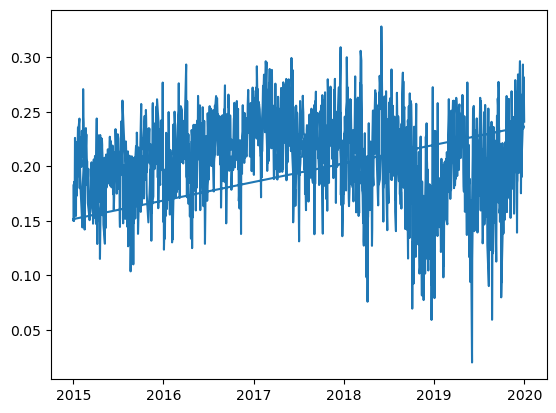

In [117]:
plt.plot(merged_df['Date'], merged_df['sentiment_score'])

Now, we again want to look at the lag1 of all the features, so X_train will contain the lag1 of all the features and y_train the volatility today (not lagged), and same for X_test & y_test:

In [118]:
#Creating Lagged Features
lags = 1  # Number of lags
for column in merged_df.columns.drop('Date'):
    for lag in range(1, lags + 1):
        merged_df[f'{column}_lag{lag}'] = merged_df[column].shift(lag)

# Dropping rows with NaN values after shifting
merged_df.dropna(inplace=True)

merged_df.head()

,Date,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,sentiment_score,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,sentiment_score_lag1
1,2015-01-06,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886,0.165909,18.00,-1.466868,36521300.0,-0.639069,0.75,0.353886,0.185542
2,2015-01-07,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886,0.182038,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886,0.165909
3,2015-01-08,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886,0.226006,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886,0.182038
4,2015-01-09,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886,0.203986,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886,0.226006
5,2015-01-12,17.88,-1.042701,34129800.0,-0.639069,0.75,0.353886,0.154517,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886,0.203986


In [119]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [120]:
#create X_train, y_train, X_test and y_test:
X_train, X_test, y_train, y_test = train_test_split(merged_df.loc[:, merged_df.columns != 'Date'], merged_df['Volatility'], test_size=0.2, shuffle=False)
X_train = X_train[['Volatility_lag1','stock_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1', 'sentiment_score_lag1']]

X_test = X_test[['Volatility_lag1','stock_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1', 'sentiment_score_lag1']]

X_train.head()

,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,sentiment_score_lag1
1,18.00,-1.466868,36521300.0,-0.639069,0.75,0.353886,0.185542
2,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886,0.165909
3,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886,0.182038
4,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886,0.226006
5,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886,0.203986


#### Now we have all the data ready, so we can try modeling:

### Modeling with the sentiment:

#### 1. Tree based methods:

In [121]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

In [122]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}


RandomForestRegressor(max_depth=4, n_estimators=71, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.10666666666666666, max_depth=1,
                          n_estimators=78, random_state=42)
{'Random Forest': {'RMSE': 1.422097510212565, 'R2': 0.8141320298251666, 'Best Params': {'n_estimators': 71, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.5260936697593377, 'R2': 0.7859534729086439, 'Best Params': {'n_estimators': 78, 'max_depth': 1, 'learning_rate': 0.10666666666666666}}}


In [123]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions['Random Forest']['y_pred']
#y_pred_ab = model_predictions['AdaBoost']['y_pred']
y_pred_gb = model_predictions['Gradient Boosting']['y_pred']

r2_rf = model_performance['Random Forest']['R2']
#r2_ab = model_performance['AdaBoost']['R2']
r2_gb = model_performance['Gradient Boosting']['R2']

rmse_rf = model_performance['Random Forest']['RMSE']
#rmse_ab = model_performance['AdaBoost']['RMSE']
rmse_gb = model_performance['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       #'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])
    

Random Forest : R2: 0.8141320298251666, RMSE: 1.422097510212565
Gradient Boosting : R2: 0.7859534729086439, RMSE: 1.5260936697593377


In [124]:
#dates for test data:
test_dates = merged_df['Date'].tail(251)

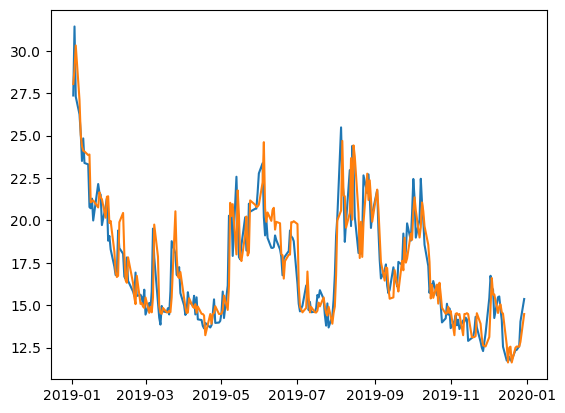

In [125]:
#plot prediction vs actual over time:
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_rf)
plt.show()

check rolling mse!!

In [126]:
#Take just volatility + sentiment:
X_train2 = X_train[['Volatility_lag1', 'sentiment_score_lag1']]
X_test2 = X_test[['Volatility_lag1', 'sentiment_score_lag1']]

X_train2.head()

,Volatility_lag1,sentiment_score_lag1
1,18.00,0.185542
2,19.05,0.165909
3,17.20,0.182038
4,16.61,0.226006
5,16.60,0.203986


In [127]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train2, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test2)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=73, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.08888888888888889, max_depth=1,
                          n_estimators=77, random_state=42)
{'Random Forest': {'RMSE': 1.4385691060286216, 'R2': 0.8098014232720977, 'Best Params': {'n_estimators': 73, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.4144941472582868, 'R2': 0.8161142338231467, 'Best Params': {'n_estimators': 77, 'max_depth': 1, 'learning_rate': 0.08888888888888889}}}


In [128]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions['Random Forest']['y_pred']
y_pred_gb = model_predictions['Gradient Boosting']['y_pred']

r2_rf = model_performance['Random Forest']['R2']
r2_gb = model_performance['Gradient Boosting']['R2']

rmse_rf = model_performance['Random Forest']['RMSE']
rmse_gb = model_performance['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])
    

Random Forest : R2: 0.8098014232720977, RMSE: 1.4385691060286216
Gradient Boosting : R2: 0.8161142338231467, RMSE: 1.4144941472582868


Feature importance:

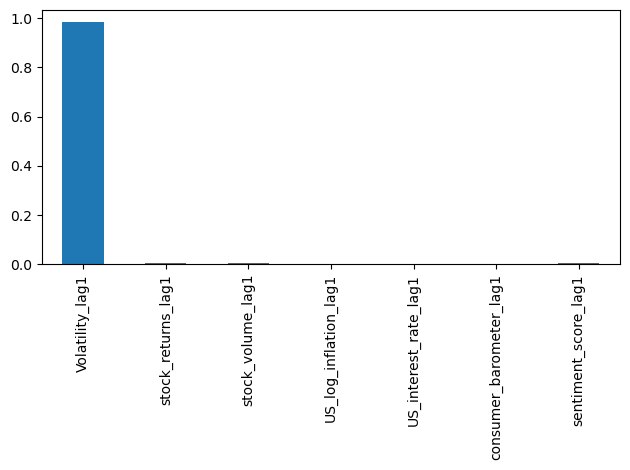

In [129]:
rf = RandomForestRegressor(max_depth=4, n_estimators=79, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
fig.tight_layout()

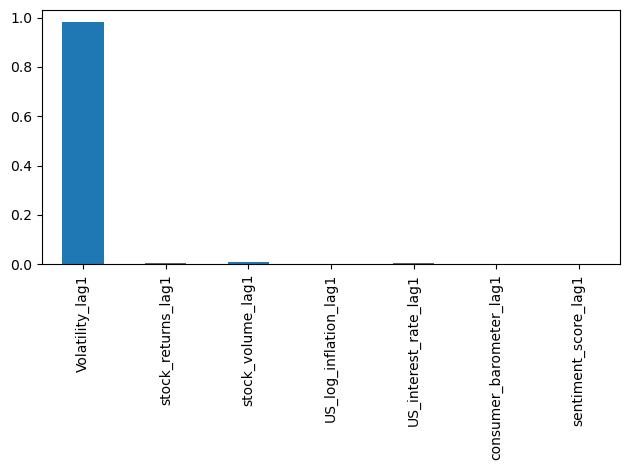

In [130]:
gb = GradientBoostingRegressor(learning_rate=0.1111111111111111, max_depth=1,
                          n_estimators=84, random_state=42)
gb.fit(X_train, y_train)
importances = pd.Series(gb.feature_importances_, index=X_train.columns)
fig, ax = plt.subplots()
importances.plot.bar( ax=ax)
fig.tight_layout()

In [131]:
feature_importance = gb.feature_importances_
feature_names = gb.feature_names_in_
pd.DataFrame({'Feature' : feature_names, 'Feature importance' :feature_importance})


,Feature,Feature importance
0,Volatility_lag1,0.981375
1,stock_returns_lag1,0.003613
2,stock_volume_lag1,0.009633
3,US_log_inflation_lag1,0.000195
4,US_interest_rate_lag1,0.003322
5,consumer_barometer_lag1,0.000000
6,sentiment_score_lag1,0.001863


Best random forest results so far!
Try rolling window:

In [132]:
X_train

,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,sentiment_score_lag1
1,18.00,-1.466868,36521300.0,-0.639069,0.75,0.353886,0.185542
2,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886,0.165909
3,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886,0.182038
4,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886,0.226006
5,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886,0.203986
...,...,...,...,...,...,...,...
1000,32.69,-3.099350,141129400.0,0.068466,3.00,0.062721,0.059273
1001,36.04,-2.479796,56163300.0,0.068466,3.00,0.062721,0.161766
1002,30.50,6.243867,98982100.0,0.068466,3.00,0.062721,0.272474
1003,33.27,0.387000,85824300.0,0.068466,3.00,0.062721,0.159129


In [111]:
X_test.columns

Index(['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1', 'sentiment_score_lag1'],
      dtype='object')

In [138]:
# Rolling window (window size is 80% of data)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Initialize lists to store MSE values and forecasts
res_MA3 = []
forecast_MA3 = []
conf_MA3 = []

X_train_roll = X_train.copy()
X_test_roll = X_test.copy()
y_train_roll = y_train.copy()
y_test_roll = y_test.copy()

for i in range(len(X_test)):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_roll)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train_roll.columns)
    X_test_scaled = scaler.transform(X_test_roll)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test_roll.columns)
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = GradientBoostingRegressor(n_estimators = 84, max_depth = 1, learning_rate = 0.1111111111111111, random_state=42) # add parameters!!! #ARIMA(train_data3, order=(0, 0, optimal_lag_bic_ma))
    model_fit = model.fit(X_train_scaled_df, y_train_roll)

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.predict(pd.DataFrame(np.array(X_test_scaled_df.iloc[i]).reshape(1, -1), columns = X_test_roll.columns))

    forecast_MA3.append(get_forecast)

    res = y_test_roll.iloc[i] - get_forecast
    res_MA3.append(res)

    # Expand estimation window
    test_to_train = pd.Series([y_test_roll.iloc[i]], index=[i])
    #print(test_to_train)
    X_train_roll = pd.concat([X_train_roll, X_test_roll.iloc[[i]]], ignore_index=True)
    y_train_roll = pd.concat([y_train_roll, test_to_train], ignore_index=True)
    X_train_roll = X_train_roll.iloc[1:]
    y_train_roll = y_train_roll.iloc[1:]
    #print(len(X_train_roll))

    #print(train_data[-5:])

# Calculate the overall average MSE
mse_MA3 = np.mean(np.square(res_MA3))
print("Overall average MSE:", mse_MA3)

#RMSE:
print("RMSE:", np.sqrt(mean_squared_error(y_test, forecast_MA3)))
#R2:
print("R2:", r2_score(y_test, forecast_MA3))

Overall average MSE: 2.0526517421093744
RMSE: 1.4327078355719893
R2: 0.8113481466466101


Held þetta sé að gera það sem ég vildi?? er ekki viss samt

In [102]:
X_test.iloc[0]

Volatility_lag1            2.911000e+01
stock_returns_lag1         8.432848e-01
stock_volume_lag1          5.301530e+07
US_log_inflation_lag1      6.846591e-02
US_interest_rate_lag1      3.000000e+00
consumer_barometer_lag1    6.272063e-02
sentiment_score_lag1       2.257181e-01
Name: 1005, dtype: float64

In [100]:
y_test.iloc[0]

27.36

In [84]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 72, 'max_depth': 4}, 
    "Gradient Boosting": {'n_estimators': 84, 'max_depth': 1, 'learning_rate': 0.1111111111111111}
}

# Assuming y_test, X_train2, X_test2, y_train are defined somewhere here

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 1004

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()
    print(actuals.head())

    # Start rolling window forecast
    for i in range(len(X_test2)):
        #start and end of rolling window:
        start_point = max(0, len(X_train2) + i - window_size)
        end_point = len(X_train2) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train2), pd.DataFrame(X_test2).iloc[:i]])
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]

        # Scale x train:
        scaler = StandardScaler()
        X_train_rolling_scaled = scaler.fit_transform(X_train_rolling)
        X_train_rolling_scaled_df = pd.DataFrame(X_train_rolling_scaled, columns = X_train_rolling.columns)
        model.set_params(**params)
        model.fit(X_train_rolling_scaled_df, y_train_rolling)
        
        # Scale x test for the current point:
        X_test_scaled = scaler.transform(X_test2.iloc[[i]])
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test2.columns)
    
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_scaled_df)
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
1005    27.36
1006    31.43
1007    27.29
1008    26.25
1009    25.11
Name: Volatility, dtype: float64


ValueError: Found input variables with inconsistent numbers of samples: [1005, 1004]

In [82]:
print(type(y_test))

<class 'pandas.core.series.Series'>


**-> Standardize on rolling window!!!**
- for each window standardize the inputs!!!!

got worse???? idk why

Expanding window instead:

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning - use the best parameters from the code above 
parameters = {
    "Random Forest": {'n_estimators': 72, 'max_depth': 4}, 
    "Gradient Boosting": {'n_estimators': 84, 'max_depth': 1, 'learning_rate': 0.1111111111111111}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Implementing expanding window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start expanding window forecast
    for i in range(len(X_test)):  # assuming X_test_lags is the test set features
        # Train model on available data
        X_train_expanding = pd.concat([X_train, X_test.iloc[:i]])
        y_train_expanding = pd.concat([y_train, y_test.iloc[:i]])
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_expanding, y_train_expanding)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test.iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.3947252125634788, 'R2': 0.8212182815115261}, 'Gradient Boosting': {'RMSE': 1.4567657765334703, 'R2': 0.8049592922373727}}


#### RNN:

Epoch 1/150
16/16 [==============================] - 4s 7ms/step - loss: 263.4100
Epoch 2/150
16/16 [==============================] - 0s 6ms/step - loss: 250.9853
Epoch 3/150
16/16 [==============================] - 0s 6ms/step - loss: 168.2061
Epoch 4/150
16/16 [==============================] - 0s 6ms/step - loss: 43.8267
Epoch 5/150
16/16 [==============================] - 0s 6ms/step - loss: 32.6002
Epoch 6/150
16/16 [==============================] - 0s 6ms/step - loss: 29.8951
Epoch 7/150
16/16 [==============================] - 0s 5ms/step - loss: 25.1452
Epoch 8/150
16/16 [==============================] - 0s 6ms/step - loss: 22.7257
Epoch 9/150
16/16 [==============================] - 0s 6ms/step - loss: 19.6574
Epoch 10/150
16/16 [==============================] - 0s 6ms/step - loss: 15.5352
Epoch 11/150
16/16 [==============================] - 0s 5ms/step - loss: 13.3821
Epoch 12/150
16/16 [==============================] - 0s 6ms/step - loss: 13.4770
Epoch 13/150
16/16 [==

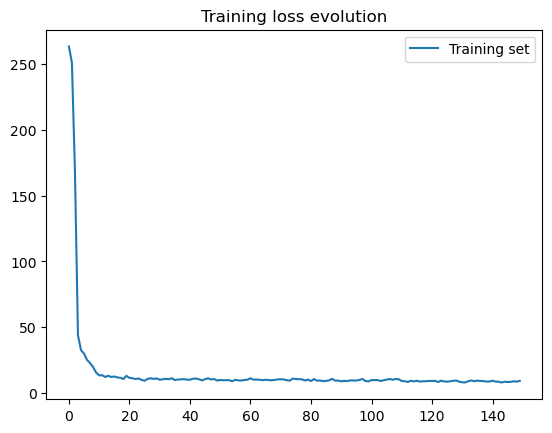

8/8 [==============================] - 1s 3ms/step
RMSE: 1.4185884336116112 R2: 0.815048169887447


In [42]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train2)
X_test_daily_scaled = scaler.transform(X_test2)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 4s 5ms/step - loss: 260.2876
Epoch 2/150
16/16 [==============================] - 0s 6ms/step - loss: 211.6225
Epoch 3/150
16/16 [==============================] - 0s 9ms/step - loss: 58.9014
Epoch 4/150
16/16 [==============================] - 0s 7ms/step - loss: 34.4679
Epoch 5/150
16/16 [==============================] - 0s 5ms/step - loss: 28.6634
Epoch 6/150
16/16 [==============================] - 0s 5ms/step - loss: 26.4290
Epoch 7/150
16/16 [==============================] - 0s 5ms/step - loss: 22.0965
Epoch 8/150
16/16 [==============================] - 0s 6ms/step - loss: 20.5245
Epoch 9/150
16/16 [==============================] - 0s 6ms/step - loss: 15.8766
Epoch 10/150
16/16 [==============================] - 0s 7ms/step - loss: 14.4098
Epoch 11/150
16/16 [==============================] - 0s 7ms/step - loss: 12.1361
Epoch 12/150
16/16 [==============================] - 0s 7ms/step - loss: 11.6895
Epoch 13/150
16/16 [===

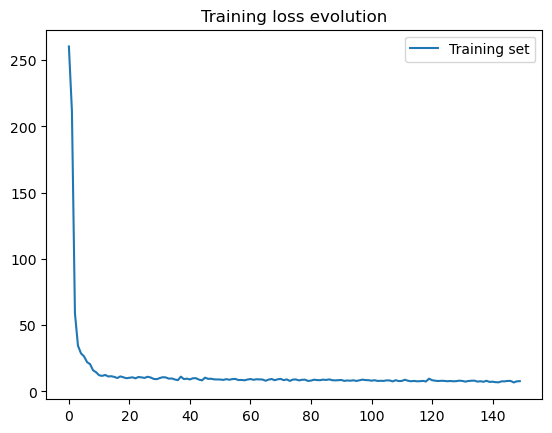

8/8 [==============================] - 1s 3ms/step
RMSE: 1.4347949702640692 R2: 0.8107980992259988


In [43]:
#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train)
X_test_daily_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 4s 6ms/step - loss: 262.0293
Epoch 2/150
16/16 [==============================] - 0s 6ms/step - loss: 232.0322
Epoch 3/150
16/16 [==============================] - 0s 6ms/step - loss: 82.3867
Epoch 4/150
16/16 [==============================] - 0s 6ms/step - loss: 36.8514
Epoch 5/150
16/16 [==============================] - 0s 6ms/step - loss: 29.7282
Epoch 6/150
16/16 [==============================] - 0s 8ms/step - loss: 27.6964
Epoch 7/150
16/16 [==============================] - 0s 8ms/step - loss: 25.2837
Epoch 8/150
16/16 [==============================] - 0s 6ms/step - loss: 23.0794
Epoch 9/150
16/16 [==============================] - 0s 7ms/step - loss: 18.8142
Epoch 10/150
16/16 [==============================] - 0s 12ms/step - loss: 16.7795
Epoch 11/150
16/16 [==============================] - 0s 8ms/step - loss: 13.9970
Epoch 12/150
16/16 [==============================] - 0s 6ms/step - loss: 12.9990
Epoch 13/150
16/16 [==

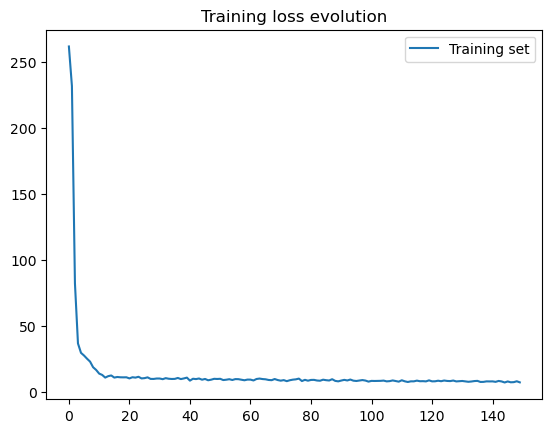

8/8 [==============================] - 2s 5ms/step
RMSE: 1.385457522338973 R2: 0.8235863303496433


In [44]:
import tensorflow as tf
# set seed: 
tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train)
X_test_daily_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


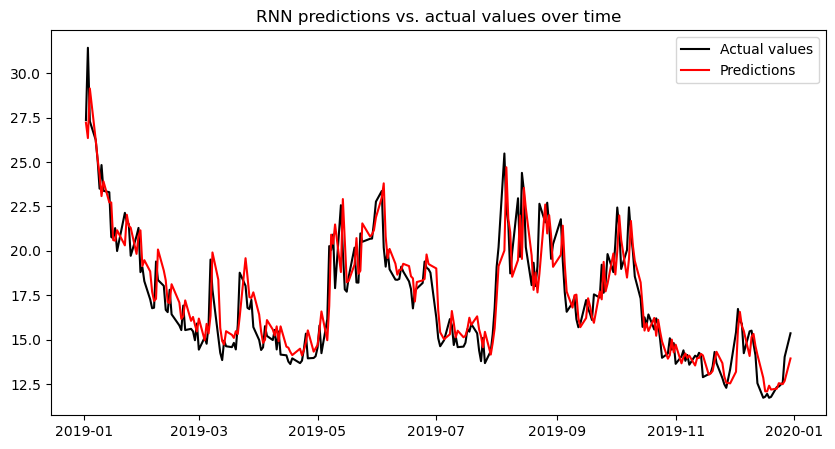

In [45]:
#plot prediction vs actual over time:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test, color = 'black')
plt.plot(test_dates, y_pred, color='red')
plt.title('RNN predictions vs. actual values over time')
plt.legend(['Actual values', 'Predictions'])
plt.show()

Lowest RMSE so far!!

In [52]:
X_train.columns

Index(['Volatility_lag1', 'stock_log_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1', 'weighted_sentiment_lag1'],
      dtype='object')

In [25]:
#now drop the interest rates and barometer stuff and see what it changes:
X_train3 = X_train[['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'sentiment_score_lag1']]
X_test3 = X_test[['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'sentiment_score_lag1']]

Epoch 1/150
16/16 [==============================] - 5s 8ms/step - loss: 263.3105
Epoch 2/150
16/16 [==============================] - 0s 8ms/step - loss: 243.8606
Epoch 3/150
16/16 [==============================] - 0s 7ms/step - loss: 121.2844
Epoch 4/150
16/16 [==============================] - 0s 8ms/step - loss: 39.0921
Epoch 5/150
16/16 [==============================] - 0s 8ms/step - loss: 34.5459
Epoch 6/150
16/16 [==============================] - 0s 8ms/step - loss: 33.8838
Epoch 7/150
16/16 [==============================] - 0s 8ms/step - loss: 30.7292
Epoch 8/150
16/16 [==============================] - 0s 8ms/step - loss: 30.3093
Epoch 9/150
16/16 [==============================] - 0s 8ms/step - loss: 31.2786
Epoch 10/150
16/16 [==============================] - 0s 8ms/step - loss: 28.2053
Epoch 11/150
16/16 [==============================] - 0s 8ms/step - loss: 27.0127
Epoch 12/150
16/16 [==============================] - 0s 8ms/step - loss: 23.9733
Epoch 13/150
16/16 [==

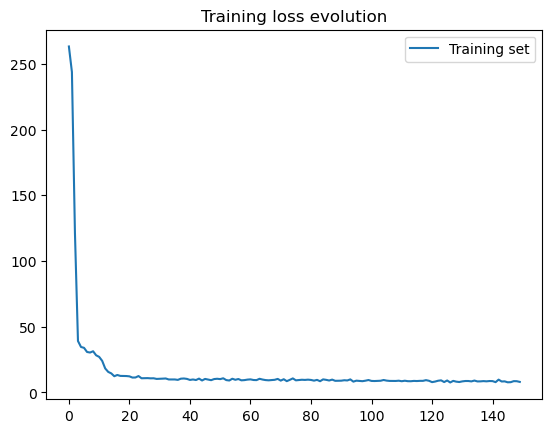

8/8 [==============================] - 1s 5ms/step
RMSE: 1.452673772837031 R2: 0.8060534782518058


In [48]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train)
X_test_daily_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 6s 9ms/step - loss: 263.6725
Epoch 2/150
16/16 [==============================] - 0s 8ms/step - loss: 251.2444
Epoch 3/150
16/16 [==============================] - 0s 9ms/step - loss: 157.1893
Epoch 4/150
16/16 [==============================] - 0s 9ms/step - loss: 38.0229
Epoch 5/150
16/16 [==============================] - 0s 8ms/step - loss: 22.4147
Epoch 6/150
16/16 [==============================] - 0s 9ms/step - loss: 21.8989
Epoch 7/150
16/16 [==============================] - 0s 9ms/step - loss: 21.8334
Epoch 8/150
16/16 [==============================] - 0s 9ms/step - loss: 22.1868
Epoch 9/150
16/16 [==============================] - 0s 9ms/step - loss: 21.8918
Epoch 10/150
16/16 [==============================] - 0s 9ms/step - loss: 21.4629
Epoch 11/150
16/16 [==============================] - 0s 9ms/step - loss: 21.6214
Epoch 12/150
16/16 [==============================] - 0s 9ms/step - loss: 21.8823
Epoch 13/150
16/16 [==

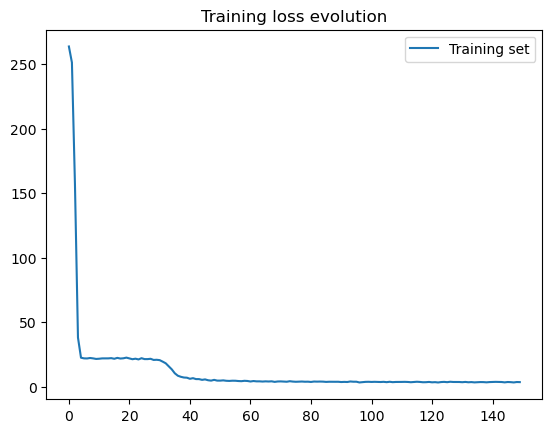

8/8 [==============================] - 1s 4ms/step
RMSE: 1.4173386606972942 R2: 0.8153739105489919


In [49]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(96, activation='tanh', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')


# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)





Add movement of the sentiment to the data, that is the difference between sentiment today and day before...

In [50]:
X_train.columns

Index(['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1', 'sentiment_score_lag1'],
      dtype='object')

In [51]:
X_train4 = X_train.copy()
X_train4['sentiment_movement'] = X_train4['sentiment_score_lag1'].diff()
X_train4.dropna(inplace=True)
X_train4.head()

X_test4 = X_test.copy()
X_test4['sentiment_movement'] = X_test4['sentiment_score_lag1'].diff()
X_test4.dropna(inplace=True)
X_test4.head()

,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,sentiment_score_lag1,sentiment_movement
1006,27.36,0.401922,58576700.0,-0.081531,3.0,-0.556296,0.079259,-0.146459
1007,31.43,-3.267036,74820200.0,-0.081531,3.0,-0.556296,0.105558,0.026298
1008,27.29,4.278461,74709300.0,-0.081531,3.0,-0.556296,0.201196,0.095638
1009,26.25,1.190564,52059300.0,-0.081531,3.0,-0.556296,0.180946,-0.020249
1010,25.11,0.904549,49388700.0,-0.081531,3.0,-0.556296,0.172368,-0.008578


In [52]:
y_train4 = y_train[1:]
y_test4 = y_test[1:]

Epoch 1/150
16/16 [==============================] - 4s 7ms/step - loss: 261.2654
Epoch 2/150
16/16 [==============================] - 0s 6ms/step - loss: 220.2445
Epoch 3/150
16/16 [==============================] - 0s 13ms/step - loss: 64.6231
Epoch 4/150
16/16 [==============================] - 0s 7ms/step - loss: 34.8114
Epoch 5/150
16/16 [==============================] - 0s 7ms/step - loss: 32.6282
Epoch 6/150
16/16 [==============================] - 0s 6ms/step - loss: 28.9200
Epoch 7/150
16/16 [==============================] - 0s 6ms/step - loss: 25.8429
Epoch 8/150
16/16 [==============================] - 0s 6ms/step - loss: 22.8974
Epoch 9/150
16/16 [==============================] - 0s 7ms/step - loss: 19.9584
Epoch 10/150
16/16 [==============================] - 0s 6ms/step - loss: 16.0413
Epoch 11/150
16/16 [==============================] - 0s 7ms/step - loss: 13.3597
Epoch 12/150
16/16 [==============================] - 0s 6ms/step - loss: 11.7913
Epoch 13/150
16/16 [==

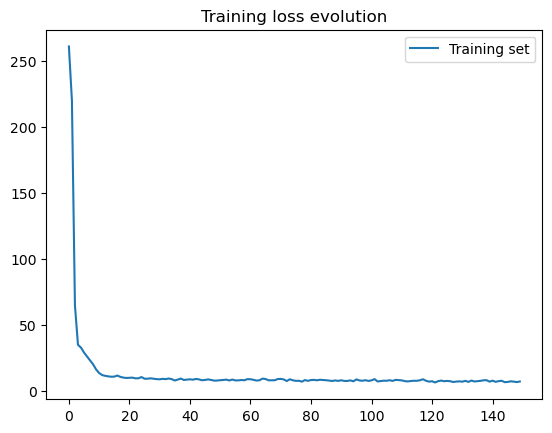

8/8 [==============================] - 1s 3ms/step
RMSE: 1.3770382880968723 R2: 0.8196434285762222


In [53]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train4)
X_test_daily_scaled = scaler.transform(X_test4)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [54]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train4, y_train4)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test4)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test4, y_pred))
    r2 = r2_score(y_test4, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=73, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.10666666666666666, max_depth=1,
                          n_estimators=83, random_state=42)
{'Random Forest': {'RMSE': 1.4150495679684096, 'R2': 0.8095490052944619, 'Best Params': {'n_estimators': 73, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.561222339355837, 'R2': 0.7681700972943803, 'Best Params': {'n_estimators': 83, 'max_depth': 1, 'learning_rate': 0.10666666666666666}}}


In [55]:
X_train4.columns

Index(['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1', 'sentiment_score_lag1',
       'sentiment_movement'],
      dtype='object')

In [56]:
X_train5 = X_train4[['Volatility_lag1', 'sentiment_score_lag1','sentiment_movement' ]]
X_test5 = X_test4[['Volatility_lag1', 'sentiment_score_lag1','sentiment_movement' ]]

In [57]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train5, y_train4)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test5)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test4, y_pred))
    r2 = r2_score(y_test4, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=74, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.08, max_depth=1, n_estimators=82,
                          random_state=42)
{'Random Forest': {'RMSE': 1.4511756069371924, 'R2': 0.7997004939075322, 'Best Params': {'n_estimators': 74, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.410552300187962, 'R2': 0.8107576527876589, 'Best Params': {'n_estimators': 82, 'max_depth': 1, 'learning_rate': 0.08}}}


(barely) but lower rmse than for x_train2 for the random forest....

Epoch 1/150
16/16 [==============================] - 5s 17ms/step - loss: 262.4884
Epoch 2/150
16/16 [==============================] - 0s 13ms/step - loss: 246.5114
Epoch 3/150
16/16 [==============================] - 0s 12ms/step - loss: 152.0824
Epoch 4/150
16/16 [==============================] - 0s 13ms/step - loss: 41.0449
Epoch 5/150
16/16 [==============================] - 0s 12ms/step - loss: 30.6595
Epoch 6/150
16/16 [==============================] - 0s 13ms/step - loss: 25.2682
Epoch 7/150
16/16 [==============================] - 0s 15ms/step - loss: 22.8540
Epoch 8/150
16/16 [==============================] - 0s 21ms/step - loss: 19.1110
Epoch 9/150
16/16 [==============================] - 0s 17ms/step - loss: 15.9370
Epoch 10/150
16/16 [==============================] - 0s 15ms/step - loss: 13.4815
Epoch 11/150
16/16 [==============================] - 0s 13ms/step - loss: 10.9656
Epoch 12/150
16/16 [==============================] - 0s 22ms/step - loss: 10.7827
Epoch 13/1

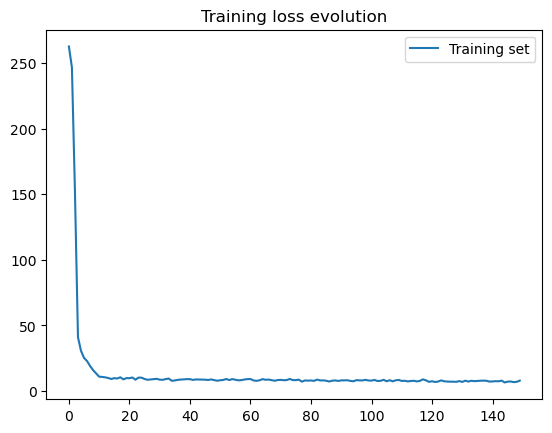

8/8 [==============================] - 1s 4ms/step
RMSE: 1.4601364271466681 R2: 0.7972192100031882


In [58]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train5)
X_test_daily_scaled = scaler.transform(X_test5)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [71]:
#!pip install keras_tuner

  Obtaining dependency information for keras_tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ------------ -------------------------- 41.0/129.1 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [73]:
# import keras_tuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers.legacy import Adam

# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences=True))
#     model.add(LSTM(100, return_sequences=True))
#     model.add(LSTM(50, return_sequences=False))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
#     model.add(Dense(1))
#     model.compile(optimizer=Adam(learning_rate=1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')
#     return model

# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=10,  # Number of different configurations to try
#     executions_per_trial=3,  # Number of models to train for each configuration
# #    directory='my_dir',  # Directory to save logs
# #    project_name='dropout_tuning'
# )

# tuner.search(X_train_daily_scaled, y_train4, epochs=50, validation_split=0.2, verbose=1, shuffle = False)

# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"Best dropout rate at first layer: {best_hps.get('dropout_1')}")
# print(f"Best dropout rate at second layer: {best_hps.get('dropout_2')}")


Trial 10 Complete [00h 02m 40s]
val_loss: 4.623396873474121

Best val_loss So Far: 3.899820566177368
Total elapsed time: 00h 19m 21s
Best dropout rate at first layer: 0.2
Best dropout rate at second layer: 0.2


Epoch 1/150
16/16 [==============================] - 5s 13ms/step - loss: 262.1579
Epoch 2/150
16/16 [==============================] - 0s 12ms/step - loss: 244.2963
Epoch 3/150
16/16 [==============================] - 0s 13ms/step - loss: 143.2431
Epoch 4/150
16/16 [==============================] - 0s 13ms/step - loss: 37.5562
Epoch 5/150
16/16 [==============================] - 0s 12ms/step - loss: 28.7118
Epoch 6/150
16/16 [==============================] - 0s 13ms/step - loss: 23.0131
Epoch 7/150
16/16 [==============================] - 0s 13ms/step - loss: 20.6619
Epoch 8/150
16/16 [==============================] - 0s 13ms/step - loss: 18.4170
Epoch 9/150
16/16 [==============================] - 0s 13ms/step - loss: 13.8531
Epoch 10/150
16/16 [==============================] - 0s 13ms/step - loss: 11.5760
Epoch 11/150
16/16 [==============================] - 0s 18ms/step - loss: 9.6673
Epoch 12/150
16/16 [==============================] - 0s 12ms/step - loss: 9.7666
Epoch 13/150

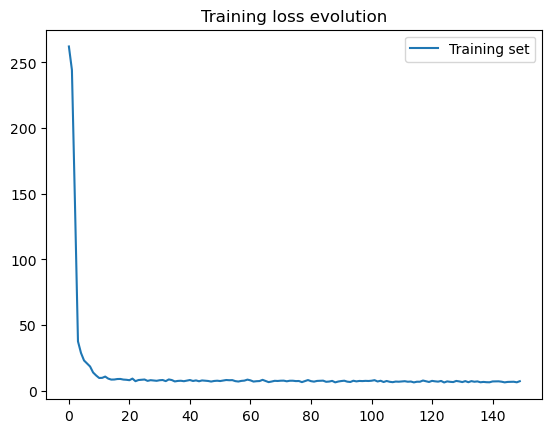

8/8 [==============================] - 1s 3ms/step
RMSE: 1.4235098178321697 R2: 0.8072648737409076


In [59]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train5)
X_test_daily_scaled = scaler.transform(X_test5)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [77]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers.legacy import Adam
# import keras_tuner as kt

# def build_model(hp):
#     model = Sequential()
#     model.add(LSTM(
#         hp.Int('units_lstm1', min_value=50, max_value=300, step=50),
#         activation='relu',
#         input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]),
#         return_sequences=True
#     ))
#     model.add(LSTM(
#         hp.Int('units_lstm2', min_value=50, max_value=300, step=50),
#         return_sequences=True
#     ))
#     model.add(LSTM(
#         hp.Int('units_lstm3', min_value=50, max_value=300, step=50),
#         return_sequences=False
#     ))
#     model.add(Dense(
#         hp.Int('units_dense1', min_value=32, max_value=128, step=32),
#         activation='relu'
#     ))
#     model.add(Dropout(0.2))  # Optimal dropout rate from previous tuning
#     model.add(Dense(
#         hp.Int('units_dense2', min_value=32, max_value=128, step=32),
#         activation='relu'
#     ))
#     model.add(Dropout(0.2))  # Optimal dropout rate from previous tuning
#     model.add(Dense(1))
#     model.compile(
#         optimizer=Adam(learning_rate=1e-3, decay=1e-4, clipvalue=1),
#         loss='mean_squared_error'
#     )
#     return model

# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=3,
#     executions_per_trial=2,
#     directory='my_dir',
#     project_name='unit_tuning'
# )

# tuner.search(X_train_daily_scaled, y_train4, epochs=50, validation_split=0.2, verbose=1, shuffle=False)

# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"Best number of units in LSTM layer 1: {best_hps.get('units_lstm1')}")
# print(f"Best number of units in LSTM layer 2: {best_hps.get('units_lstm2')}")
# print(f"Best number of units in LSTM layer 3: {best_hps.get('units_lstm3')}")
# print(f"Best number of units in Dense layer 1: {best_hps.get('units_dense1')}")
# print(f"Best number of units in Dense layer 2: {best_hps.get('units_dense2')}")

Trial 3 Complete [00h 01m 19s]
val_loss: 5.732531309127808

Best val_loss So Far: 3.4493906497955322
Total elapsed time: 00h 06m 00s
Best number of units in LSTM layer 1: 250
Best number of units in LSTM layer 2: 100
Best number of units in LSTM layer 3: 200
Best number of units in Dense layer 1: 128
Best number of units in Dense layer 2: 64


Epoch 1/150
16/16 [==============================] - 5s 13ms/step - loss: 260.1112
Epoch 2/150
16/16 [==============================] - 0s 15ms/step - loss: 201.2122
Epoch 3/150
16/16 [==============================] - 0s 13ms/step - loss: 46.9265
Epoch 4/150
16/16 [==============================] - 0s 12ms/step - loss: 24.8238
Epoch 5/150
16/16 [==============================] - 0s 13ms/step - loss: 19.8030
Epoch 6/150
16/16 [==============================] - 0s 12ms/step - loss: 15.9868
Epoch 7/150
16/16 [==============================] - 0s 15ms/step - loss: 11.8313
Epoch 8/150
16/16 [==============================] - 0s 13ms/step - loss: 8.6942
Epoch 9/150
16/16 [==============================] - 0s 13ms/step - loss: 6.6399
Epoch 10/150
16/16 [==============================] - 0s 13ms/step - loss: 6.5564
Epoch 11/150
16/16 [==============================] - 0s 15ms/step - loss: 7.0259
Epoch 12/150
16/16 [==============================] - 0s 13ms/step - loss: 6.2888
Epoch 13/150
16/

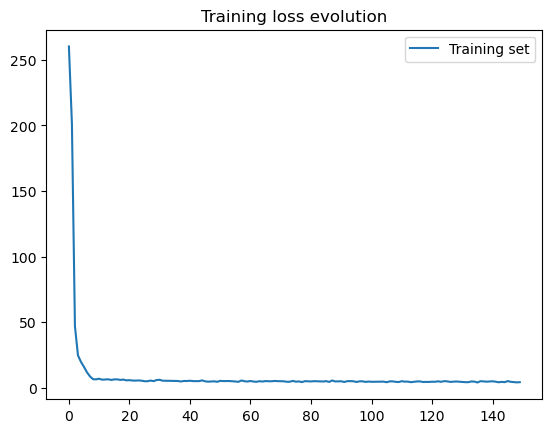

8/8 [==============================] - 1s 5ms/step
RMSE: 1.4168603727211446 R2: 0.8090612623421096


In [60]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train5)
X_test_daily_scaled = scaler.transform(X_test5)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(250, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(200, return_sequences = False))
model.add(Dense(128, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 6s 17ms/step - loss: 256.2167
Epoch 2/150
16/16 [==============================] - 0s 18ms/step - loss: 132.3058
Epoch 3/150
16/16 [==============================] - 0s 17ms/step - loss: 36.8556
Epoch 4/150
16/16 [==============================] - 0s 16ms/step - loss: 22.8117
Epoch 5/150
16/16 [==============================] - 0s 19ms/step - loss: 18.4723
Epoch 6/150
16/16 [==============================] - 0s 18ms/step - loss: 16.2191
Epoch 7/150
16/16 [==============================] - 0s 27ms/step - loss: 12.7053
Epoch 8/150
16/16 [==============================] - 1s 33ms/step - loss: 9.2359
Epoch 9/150
16/16 [==============================] - 0s 26ms/step - loss: 6.5002
Epoch 10/150
16/16 [==============================] - 0s 19ms/step - loss: 5.6398
Epoch 11/150
16/16 [==============================] - 0s 17ms/step - loss: 5.9982
Epoch 12/150
16/16 [==============================] - 0s 19ms/step - loss: 5.3561
Epoch 13/150
16/

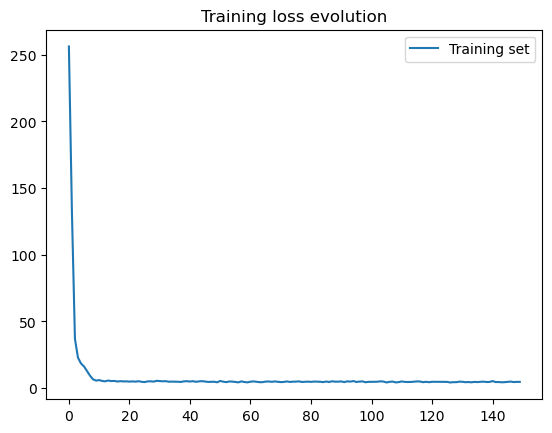

8/8 [==============================] - 2s 11ms/step
RMSE: 1.401253903254047 R2: 0.8132444101101222


In [61]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train5)
X_test_daily_scaled = scaler.transform(X_test5)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(250, activation='tanh', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(200, return_sequences = False))
model.add(Dense(128, activation='tanh'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [67]:
#method from ISLP, first start with linear regression as a benchmark:
from sklearn.linear_model import LinearRegression
M = LinearRegression(fit_intercept=True)
M.fit(X_train, y_train)
M.score(X_test, y_test)

0.8287825070403192

In [69]:
y_pred = M.predict(X_test)
r2_score(y_test, y_pred)

0.8287825070403192

Think this is basically equivalent to a VAR model!!

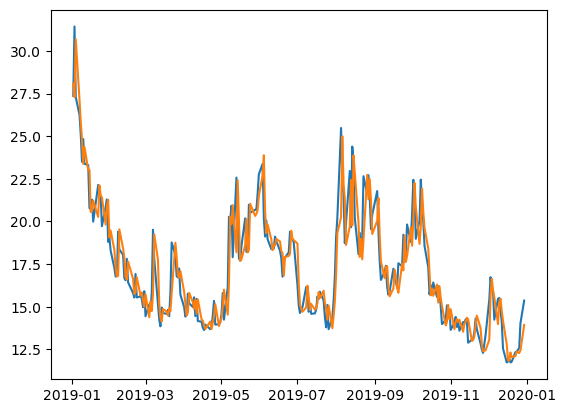

In [77]:
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred)

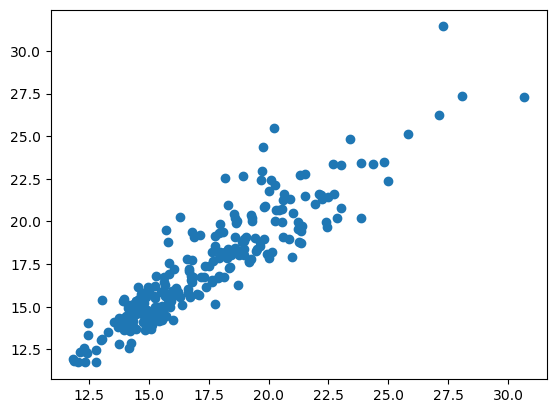

In [75]:
#plt.scatter(X_test['Volatility_lag1'], y_test)
plt.scatter(y_pred, y_test)

In [70]:
np.sqrt(mean_squared_error(y_test,y_pred))

1.3649010404409068

In [66]:
X_train.columns

Index(['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1', 'sentiment_score_lag1'],
      dtype='object')

In [71]:
M.coef_

array([ 8.95813355e-01,  7.88361913e-02,  9.18040928e-09, -5.58367071e-01,
        9.53661125e-02, -4.67428240e-02, -4.43524880e+00])

Highest coefficients are for the volatility itself and the sentiment index!

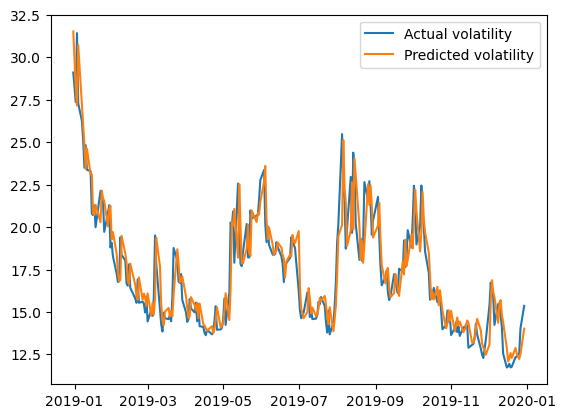

In [89]:
plt.plot(test_dates, y_test, label = 'Actual volatility')
plt.plot(test_dates, y_pred, label = 'Predicted volatility')
plt.legend()

In [79]:
#method from ISLP, first start with linear regression as a benchmark:
#just with sentiment and volatility:
from sklearn.linear_model import LinearRegression
M = LinearRegression(fit_intercept=True)
M.fit(X_train2, y_train)
M.score(X_test2, y_test)

0.8238874473328606

In [80]:
y_pred = M.predict(X_test2)
np.sqrt(mean_squared_error(y_test,y_pred))

1.384274612410489

Try AR(1) with just the volatility itself:

In [36]:
#method from ISLP, first start with linear regression as a benchmark:
from sklearn.linear_model import LinearRegression
M = LinearRegression(fit_intercept=True)
M.fit(np.array(X_train['Volatility_lag1']).reshape(-1, 1), y_train)
M.score(np.array(X_test['Volatility_lag1']).reshape(-1, 1), y_test)

0.8268413535046003

worse...

Epoch 1/200
16/16 [==============================] - 1s 1ms/step - loss: 262.9505
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 252.3076
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 242.6622
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 233.5896
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 224.5747
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 216.1878
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 208.3062
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 199.6250
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 191.9623
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 184.6797
Epoch 11/200
16/16 [==============================] - 0s 1ms/step - loss: 177.1938
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 168.9008
Epoch 13/200


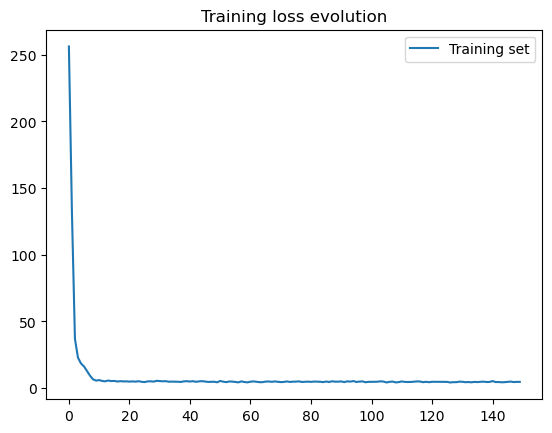

8/8 [==============================] - 0s 2ms/step
RMSE: 1.4436622047922176 R2: 0.8084522841572923


In [81]:
#ISLP model:
import tensorflow as tf
# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train)
X_test_daily_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))


class ISLP(tf.keras.Model):
    def __init__(self):
        super(ISLP, self).__init__()
        self.rnn = tf.keras.layers.SimpleRNN(12, return_sequences=True)
        self.dense = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(0.1)
        
    def call(self, x):
        val = self.rnn(x)
        val = self.dense(self.dropout(val[:, -1]))
        return tf.reshape(val, [-1])

islp_model = ISLP()

islp_model.compile(optimizer='RMSprop', loss='mean_squared_error')
islp_model.fit(X_train_daily_scaled, y_train, epochs = 200, batch_size=64)
islp_model.summary()


plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = islp_model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


SVM?

In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVR
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

Do the AR as input for neural net like ISLP book -> just means to take the lagged variables as input, which is what ive been doing the whole time

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred = model.predict(X_test_scaled)

Epoch 1/50
26/26 [==============================] - 1s 9ms/step - loss: 203.1533 - val_loss: 274.7621
Epoch 2/50
26/26 [==============================] - 0s 3ms/step - loss: 113.5931 - val_loss: 139.3955
Epoch 3/50
26/26 [==============================] - 0s 3ms/step - loss: 29.6627 - val_loss: 60.8819
Epoch 4/50
26/26 [==============================] - 0s 3ms/step - loss: 15.1606 - val_loss: 51.1322
Epoch 5/50
26/26 [==============================] - 0s 3ms/step - loss: 12.5746 - val_loss: 43.6635
Epoch 6/50
26/26 [==============================] - 0s 3ms/step - loss: 11.0198 - val_loss: 36.0579
Epoch 7/50
26/26 [==============================] - 0s 2ms/step - loss: 9.8293 - val_loss: 30.7799
Epoch 8/50
26/26 [==============================] - 0s 3ms/step - loss: 8.8430 - val_loss: 25.5676
Epoch 9/50
26/26 [==============================] - 0s 3ms/step - loss: 8.0037 - val_loss: 20.8503
Epoch 10/50
26/26 [==============================] - 0s 3ms/step - loss: 7.1763 - val_loss: 16.5245

In [83]:
np.sqrt(mean_squared_error(y_test, y_pred))

3.3699614843662014

--------------------------------------------------------------------------------------

### Models with new sentiment index:

In [5]:
sentiment_index_log_weighed_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_log_weighted.xlsx')

sentiment_index_log_weighed_df.head()

,date,sentiment_score
0,2015-01-02,0.149896
1,2015-01-05,0.185542
2,2015-01-06,0.165909
3,2015-01-07,0.182038
4,2015-01-08,0.226006


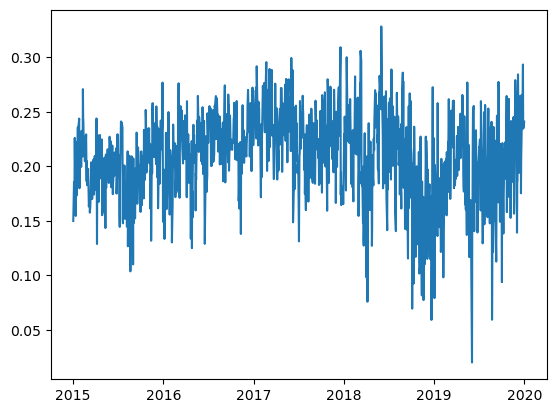

In [6]:
plt.plot(sentiment_index_log_weighed_df['date'], sentiment_index_log_weighed_df['sentiment_score'])

In [7]:
sentiment_index_log_weighed_df.rename(columns={'date' : 'Date'}, inplace=True)

In [16]:
merged_df = pd.merge(merged_df, 
                     sentiment_index_log_weighed_df[['Date', 'sentiment_score']], 
                     on='Date', 
                     how='inner')
merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,sentiment_score
0,2015-01-02,16.59,-0.142669,1435150000,-0.639069,0.75,0.353886,0.149896
1,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886,0.185542
2,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886,0.165909
3,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886,0.182038
4,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886,0.226006


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Creating Lagged Features
#lags = 1  # Number of lags
#for column in merged_df.columns.drop('Date'):
#    for lag in range(1, lags + 1):
#        merged_df[f'{column}_lag{lag}'] = merged_df[column].shift(lag)

# Dropping rows with NaN values after shifting
#merged_df.dropna(inplace=True)

#merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,sentiment_score,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,sentiment_score_lag1
1,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886,0.185542,16.59,-0.142669,1.435150e+09,-0.639069,0.75,0.353886,0.149896
2,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886,0.165909,18.00,-1.651298,1.794470e+09,-0.639069,0.75,0.353886,0.185542
3,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886,0.182038,19.05,-1.212083,2.167320e+09,-0.639069,0.75,0.353886,0.165909
4,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886,0.226006,17.20,1.189010,1.957950e+09,-0.639069,0.75,0.353886,0.182038
5,2015-01-09,16.60,-0.645154,1715830000,-0.639069,0.75,0.353886,0.203986,16.61,1.917786,2.105450e+09,-0.639069,0.75,0.353886,0.226006


In [18]:
#create X_train, y_train, X_test and y_test:
X_train, X_test, y_train, y_test = train_test_split(merged_df.loc[:, merged_df.columns != 'Date'], merged_df['Volatility'], test_size=0.2, shuffle=False)
X_train = X_train[['Volatility_lag1','stock_log_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1', 'sentiment_score_lag1']]

X_test = X_test[['Volatility_lag1','stock_log_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1', 'sentiment_score_lag1']]

X_train.head()

,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,sentiment_score_lag1
1,16.59,-0.142669,1.435150e+09,-0.639069,0.75,0.353886,0.149896
2,18.00,-1.651298,1.794470e+09,-0.639069,0.75,0.353886,0.185542
3,19.05,-1.212083,2.167320e+09,-0.639069,0.75,0.353886,0.165909
4,17.20,1.189010,1.957950e+09,-0.639069,0.75,0.353886,0.182038
5,16.61,1.917786,2.105450e+09,-0.639069,0.75,0.353886,0.226006


In [22]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=76, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.1111111111111111, max_depth=1,
                          n_estimators=80, random_state=42)
{'Random Forest': {'RMSE': 1.4805419718868769, 'R2': 0.8076051163256665, 'Best Params': {'n_estimators': 76, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.5747433097971928, 'R2': 0.7823435130623401, 'Best Params': {'n_estimators': 80, 'max_depth': 1, 'learning_rate': 0.1111111111111111}}}


previous sentiment score results: 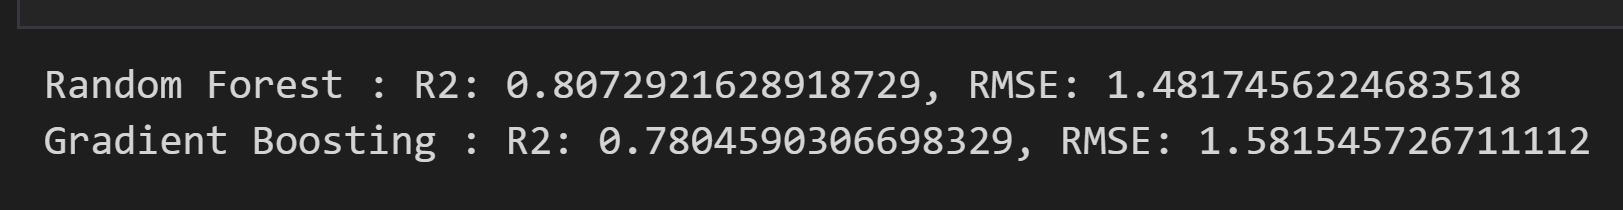

In [ ]:
# try with just volatility and sentiment not all the other stuff (like X_train2 and X_test2)

More: Experiment more with XGBOOST!!

In [84]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming `merged_df` is your preprocessed dataset ready for modeling
#X = merged_df.drop(['Date', 'Volatility'], axis=1)  # Features
#y = merged_df['Volatility']  # Target variable

# Splitting the dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predicting and evaluating
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 1.5569780089224914


Bayesian ridge regression:

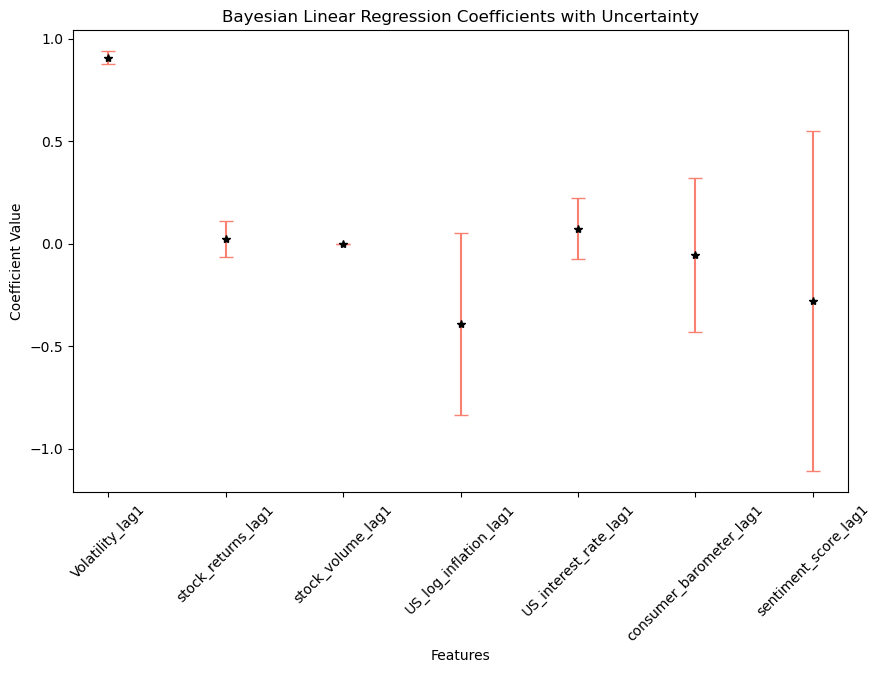

In [37]:
from sklearn.linear_model import BayesianRidge
# Bayesian Linear Regression
bayesian_model = BayesianRidge() #stick with the default values of parameters
bayesian_model.fit(X_train.loc[:,X_train.columns != 'Volatility'], y_train)
y_pred_bayesian, y_pred_bayesian_std = bayesian_model.predict(X_test.loc[:,X_test.columns != 'Volatility'], return_std=True) #predict and return mean and std


# Extract the standard deviation of the coefficients
std_dev_coef = np.sqrt(np.diag(bayesian_model.sigma_)) #sigma contains covariacne matrix of coefficients

# Plotting the coefficient values along with standard deviation (uncertainty)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(bayesian_model.coef_)), bayesian_model.coef_,
             yerr=1.96*std_dev_coef, # 1.96 for 95% confidence interval
             fmt='*k', # make the means stars just for fun
             ecolor='salmon', # color of error bars, salmon is prettier than red
             capsize=5)
plt.xticks(range(len(bayesian_model.coef_)), X_train.columns[X_train.columns != 'Volatility'], rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Bayesian Linear Regression Coefficients with Uncertainty')
plt.show()

In [38]:
bayesian_model.coef_

array([ 9.08685041e-01,  2.29452055e-02,  1.02604176e-08, -3.90169306e-01,
        7.35464903e-02, -5.58477543e-02, -2.79315133e-01])

In [39]:
r2_bayes = r2_score(y_test, y_pred_bayesian)
rmse_bayes = np.sqrt(mean_squared_error(y_test, y_pred_bayesian))

print(f"R2 score: {r2_bayes}, RMSE score: {rmse_bayes}")

R2 score: 0.8306312891196284, RMSE score: 1.3575120365274564
